In [6]:
# Notebook draws the training data in the pickle file.
import pickle
import matplotlib.pyplot as plt


In [7]:
def plot_agent_feature(one_data):
    agent_size, hist_timestamps, _ = one_data['agent_history_feature'].shape
    agent_size, furt_timestamps, _ = one_data['agent_future_feature'].shape
    valid_agent = 0
    for agent_idx in range(agent_size):
        col = [agent_idx, agent_idx]
        is_valid = False
        for ts in range(hist_timestamps):
            if one_data['agent_history_feature'][agent_idx, ts, 9]:
                plt.scatter(one_data['agent_history_feature'][agent_idx, ts, 0],
                            one_data['agent_history_feature'][agent_idx, ts, 1],
                            c=agent_idx + 1, cmap='magma', s=3)
                is_valid = True
        for ts in range(furt_timestamps):
            if one_data['agent_future_feature'][agent_idx, ts, 3]:
                plt.scatter(one_data['agent_future_feature'][agent_idx, ts, 0],
                            one_data['agent_future_feature'][agent_idx, ts, 1],
                            c=agent_idx + 1, cmap='magma', s=3)
                is_valid = True
        if is_valid:
            valid_agent += 1
    return valid_agent

def plot_map_feature(one_data):
    num_polyline, _ = one_data['map_feature'].shape
    max_dist_to_ego = 0
    for polyline_idx in range(num_polyline):
        if one_data['map_feature'][polyline_idx, 10]:
            plt.scatter(one_data['map_feature'][polyline_idx, 0], 
                        one_data['map_feature'][polyline_idx, 1],
                        c=one_data['map_feature'][polyline_idx, 8],
                        cmap='Blues_r', s=2)
            max_dist_to_ego = max(max_dist_to_ego, one_data['map_feature'][polyline_idx, 6])
    return max_dist_to_ego

In [11]:
pickle_file_path = '/home/willch/Proj/waymo_open_challenage/pickle_files/' + \
    'validating/converted_pickle_data-00002-of-00150.pickle'
with open(pickle_file_path, 'rb') as handle:
    converted_data_set = pickle.load(handle)
    

In [12]:
print (len(converted_data_set))
one_data = converted_data_set[1]

301


(-50.0, 50.0)

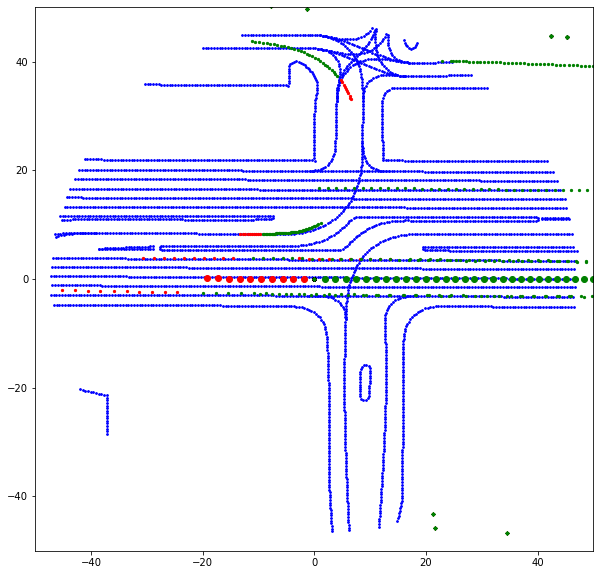

In [13]:
# quick plot of map
fig=plt.figure(figsize=(10, 10))
plt.scatter(one_data['map_feature'][:, 0], one_data['map_feature'][:, 1], s=3, c='b')
plt.scatter(one_data['sdc_history_feature'][:, 0], one_data['sdc_history_feature'][:, 1], c='r')
plt.scatter(one_data['sdc_future_feature'][:, 0], one_data['sdc_future_feature'][:, 1], c='g') 
plt.scatter(one_data['agent_history_feature'][:, :, 0], one_data['agent_history_feature'][:, :, 1], c='r', s=5)
plt.scatter(one_data['agent_future_feature'][:, :, 0], one_data['agent_future_feature'][:, :, 1], c='g', s=5)
plt.xlim([-50, 50])
plt.ylim([-50, 50])

In [14]:
one_data['sdc_future_feature'].shape

(80, 3)

num of valid agent 64
max dist is 41.67938856033282


(-41.67938856033282, 41.67938856033282)

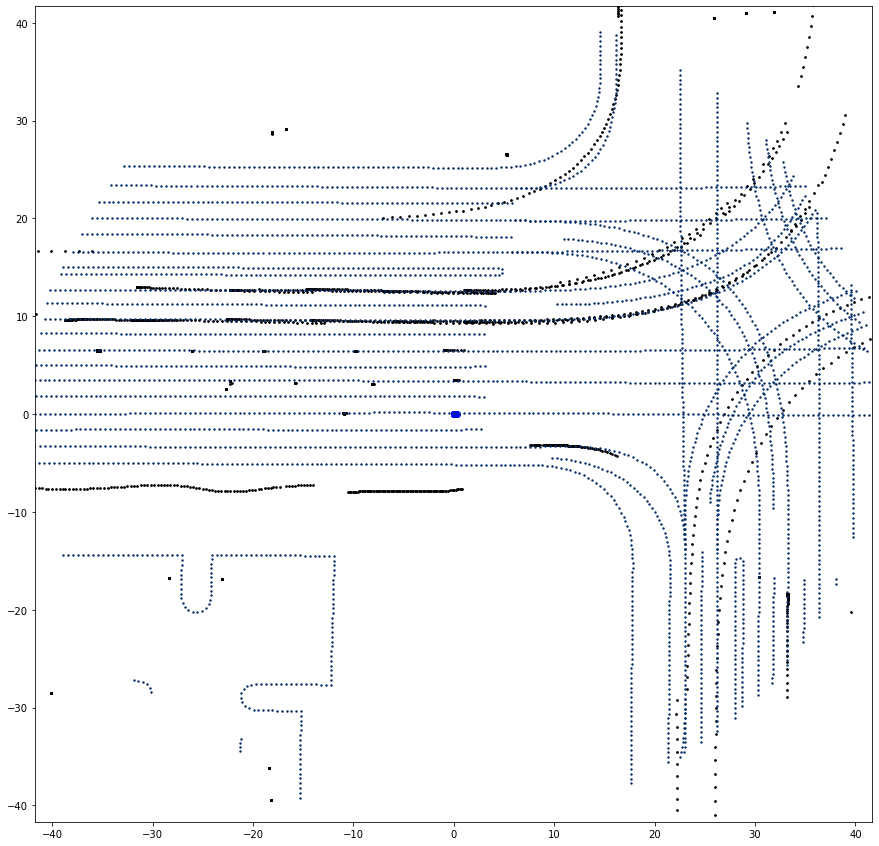

In [101]:
fig=plt.figure(figsize=(15, 15))

plt.scatter(one_data['sdc_history_feature'][:, 0], one_data['sdc_history_feature'][:, 1], c='r')
plt.scatter(one_data['sdc_future_feature'][:, 0], one_data['sdc_future_feature'][:, 1], c='b') 
num_valid_agent = plot_agent_feature(one_data)
max_dist = plot_map_feature(one_data)
print('num of valid agent ' + str(num_valid_agent))
print('max dist is ' + str(max_dist))
plt.xlim([-max_dist, max_dist])
plt.ylim([-max_dist, max_dist])
plt.show()

In [16]:
# Loads the torch model and query it.
import sys

sys.path.insert(0, '/home/willch/Proj/waymo_open_challenage')

import torch
from waymo_open_data_model_play.model.navie_model import BaselineSimplyMp


In [18]:
saved_model_path = '/home/willch/Proj/waymo_open_challenage/trained_models/' + \
    'baseline_simple_mp/v0/0_epoch.pth'

model = BaselineSimplyMp(num_future_states=80, num_trajs=3,
    history_timestamps=10, sdc_attribution_dim=10,
    agent_attribution_dim=10, map_attribution_dim=11)
model.load_state_dict(torch.load(saved_model_path))
model.eval()



BaselineSimplyMp(
  (sdc_history_encoder): MlpNet(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear_relu_stack): Sequential(
      (0): Linear(in_features=100, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (agent_history_mlp_pre_cg_encoder): MlpNet(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear_relu_stack): Sequential(
      (0): Linear(in_features=100, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (agent_history_encoder): CgNet(
    (elem_mlp): MlpNet(
      (flatten): Flatten(start_dim=1, end_dim=-1)
      (linear_relu_stack): Sequential(
        (0): Linear(in_features=32, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=64, bias=True)
      )
    )
    (ctx_mlp): MlpNet(
      (flatten): Flatten(start_dim=1, end_dim=-1)
      (linear_relu_stack): Sequential(
    

In [25]:
print( one_data['agent_history_feature'].reshape(1, 4096, 11).shape)

ValueError: cannot reshape array of size 6400 into shape (1,4096,11)

In [34]:
print(sdc_history_feature.shape)

torch.Size([1, 10, 10])


In [32]:
map_feature = torch.tensor(one_data['map_feature'].reshape(1, 4096, 11))
sdc_history_feature = torch.tensor(one_data['sdc_history_feature'].reshape(1, 10, 10))
agent_history_feature = torch.tensor(one_data['agent_history_feature'].reshape(1, 64, 10, 10))

regression, logit = model(map_feature, sdc_history_feature, agent_history_feature)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x45056 and 100x64)